Loading image: chess-board.jpg
Running Detectors on Original...
Running Rotation Test (45 degrees)...


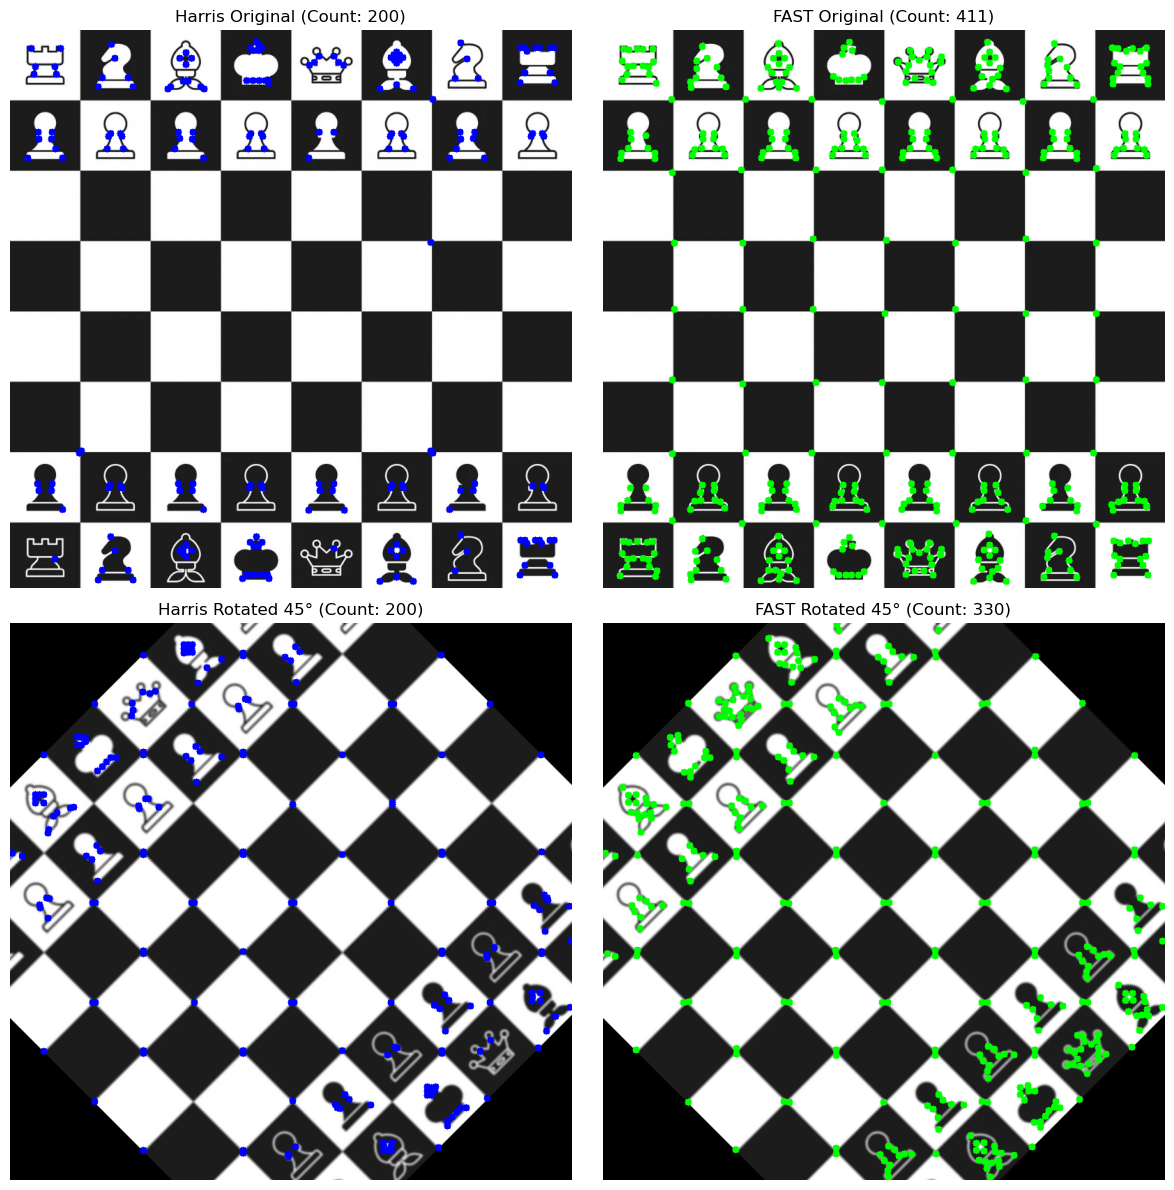

In [5]:
"""
Project: Improved Harris & FAST Corner Detection with Rotation Test
Author: Raj Antala

Description:
This script implements improved versions of the Harris and FAST
corner detectors using:
- Score-based sorting
- Non-Maximum Suppression (NMS)
- Rotation invariance testing

The goal is to compare both detectors on:
1. Original image
2. Rotated image (45 degrees)

"""

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, uniform_filter, maximum_filter, gaussian_filter
import os

# =============================================================================
#                          1. IMPROVED HARRIS 
# =============================================================================
def harris_corners_improved(gray_img, block_size=3, k=0.04, top_n=200, nms_radius=5, sub_pixel=False):
    """
    Standard Harris with improved NMS and Score Sorting.
    """
    img = gray_img.astype(np.float32)
    # 1. Gradients
    Ix = sobel(img, axis=1, mode='reflect')
    Iy = sobel(img, axis=0, mode='reflect')

    # 2. Structure Tensor
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy

    # 3. Summation (Optimized)
    window_area = block_size ** 2
    Sxx = uniform_filter(Ixx, size=block_size) * window_area
    Syy = uniform_filter(Iyy, size=block_size) * window_area
    Sxy = uniform_filter(Ixy, size=block_size) * window_area

    # 4. Response
    det_M = (Sxx * Syy) - (Sxy ** 2)
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)

    # 5. NMS & Thresholding
    local_max = maximum_filter(R, size=nms_radius)
    thr = 0.01 * R.max()
    corner_mask = (R == local_max) & (R > thr)
    
    y_inds, x_inds = np.nonzero(corner_mask)
    scores = R[y_inds, x_inds]

    # 6. Top N Sorting
    if len(scores) > top_n:
        sorted_indices = np.argsort(scores)[::-1]
        top_indices = sorted_indices[:top_n]
        y_inds = y_inds[top_indices]
        x_inds = x_inds[top_indices]
    
    corners = list(zip(y_inds, x_inds))
    return corners

# =============================================================================
#                          2. IMPROVED FAST 
# =============================================================================
def fast_corners_improved(gray_img, threshold=20, n=9, nms_radius=5):
    """
    FAST with Score-based NMS.
    IMPROVEMENT: 'nms_radius' increased to handle blurred images.
    """
    if gray_img.dtype != np.uint8:
        gray_img = gray_img.astype(np.uint8)
    
    height, width = gray_img.shape
    raw_corners = [] 

    # Standard FAST offsets (Radius 3)
    circle = [
        (0, 3), (1, 3), (2, 2), (3, 1), (3, 0), (3, -1), (2, -2), (1, -3),
        (0, -3), (-1, -3), (-2, -2), (-3, -1), (-3, 0), (-3, 1), (-2, 2), (-1, 3)
    ]

    # 1. Detection Loop
    for y in range(3, height - 3):
        for x in range(3, width - 3):
            center_v = int(gray_img[y, x])
            
            # Quick check cardinals
            cardinals = [0, 4, 8, 12]
            if sum(1 for k in cardinals if abs(int(gray_img[y+circle[k][1], x+circle[k][0]]) - center_v) > threshold) < 3:
                continue

            pixels = [int(gray_img[y+dy, x+dx]) for dx, dy in circle]
            pixels_dbl = pixels + pixels
            
            is_corner = False
            max_score = 0
            
            # Check Brighter
            for i in range(16):
                if all(p > center_v + threshold for p in pixels_dbl[i:i+n]):
                    is_corner = True
                    max_score = max(max_score, sum(abs(p - center_v) for p in pixels_dbl[i:i+n]))
            
            # Check Darker
            if not is_corner:
                for i in range(16):
                    if all(p < center_v - threshold for p in pixels_dbl[i:i+n]):
                        is_corner = True
                        max_score = max(max_score, sum(abs(p - center_v) for p in pixels_dbl[i:i+n]))
            
            if is_corner:
                raw_corners.append((max_score, y, x))

    # 2. Score-based NMS (The Fix for Clustering)
    raw_corners.sort(key=lambda x: x[0], reverse=True)
    
    final_corners = []
    # Mask to keep track of suppressed areas
    suppression_mask = np.zeros((height, width), dtype=bool)
    
    for score, cy, cx in raw_corners:
        if suppression_mask[cy, cx]:
            continue
            
        final_corners.append((cy, cx))
        
        # Suppress a square window around the corner
        y_min = max(0, cy - nms_radius)
        y_max = min(height, cy + nms_radius + 1)
        x_min = max(0, cx - nms_radius)
        x_max = min(width, cx + nms_radius + 1)
        
        suppression_mask[y_min:y_max, x_min:x_max] = True
        
    return final_corners

# =============================================================================
#                          3. INTERMEDIATE TASK: ROTATION TEST
# =============================================================================
def rotate_image(image, angle):
    """Rotates an image by a specific angle around its center."""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def main():
    # ---------------------------------------------------------
    # CONFIGURATION: Set your image filename here
    image_path = "chess-board.jpg"
    # ---------------------------------------------------------

    # 1. Load Image or Create Fallback
    if not os.path.exists(image_path):
        print(f"Warning: '{image_path}' not found. Creating synthetic image for demo.")
        img = np.zeros((400, 400), dtype=np.uint8)
        tile_size = 40
        for y in range(0, 400, tile_size):
            for x in range(0, 400, tile_size):
                if (x // tile_size + y // tile_size) % 2 == 0:
                    img[y:y+tile_size, x:x+tile_size] = 255
    else:
        print(f"Loading image: {image_path}")
        original_bgr = cv2.imread(image_path)
        if original_bgr is None:
            print("Error: Failed to decode image.")
            return
        img = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2GRAY)
        # Optional: Resize if image is huge to keep processing fast
        if img.shape[0] > 800:
            scale = 800 / img.shape[0]
            img = cv2.resize(img, None, fx=scale, fy=scale)

    # Gaussian Blur (Essential for feature detection stability)
    # We use a small blur to remove noise and soften edges
    img_blurred = cv2.GaussianBlur(img, (5, 5), 1.5)

    # 2. Run Detectors on Original
    print("Running Detectors on Original...")
    harris_pts = harris_corners_improved(img_blurred, top_n=200, nms_radius=5)
    fast_pts = fast_corners_improved(img_blurred, threshold=30, n=9, nms_radius=7)

    # 3. Intermediate Task: Rotation Invariance Check
    print("Running Rotation Test (45 degrees)...")
    img_rot = rotate_image(img_blurred, 45)
    
    # We expect corners to be found in the rotated image too
    harris_rot = harris_corners_improved(img_rot, top_n=200, nms_radius=5)
    fast_rot = fast_corners_improved(img_rot, threshold=30, n=9, nms_radius=7)

    # 4. Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    def draw_corners(image, corners, color):
        out = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        for y, x in corners:
            cv2.circle(out, (int(x), int(y)), 5, color, -1)
        return out

    # Top Row: Original
    axes[0, 0].imshow(draw_corners(img, harris_pts, (0, 0, 255))) # Red
    axes[0, 0].set_title(f"Harris Original (Count: {len(harris_pts)})")
    
    axes[0, 1].imshow(draw_corners(img, fast_pts, (0, 255, 0))) # Green
    axes[0, 1].set_title(f"FAST Original (Count: {len(fast_pts)})")
    
    # Bottom Row: Rotated
    axes[1, 0].imshow(draw_corners(img_rot, harris_rot, (0, 0, 255)))
    axes[1, 0].set_title(f"Harris Rotated 45° (Count: {len(harris_rot)})")
    
    axes[1, 1].imshow(draw_corners(img_rot, fast_rot, (0, 255, 0)))
    axes[1, 1].set_title(f"FAST Rotated 45° (Count: {len(fast_rot)})")

    for ax in axes.flatten(): ax.axis("off")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Loaded image: chess-board.jpg | Shape: (993, 1000)

--- Running Multi-Scale HARRIS ---
Level 0 | Scale: 1.00 | Corners: 500
Level 1 | Scale: 2.00 | Corners: 434
Level 2 | Scale: 4.00 | Corners: 317
Level 3 | Scale: 8.00 | Corners: 137

--- Running Multi-Scale FAST ---
Level 0 | Scale: 1.00 | Corners: 683
Level 1 | Scale: 2.00 | Corners: 354
Level 2 | Scale: 4.00 | Corners: 180
Level 3 | Scale: 8.00 | Corners: 83


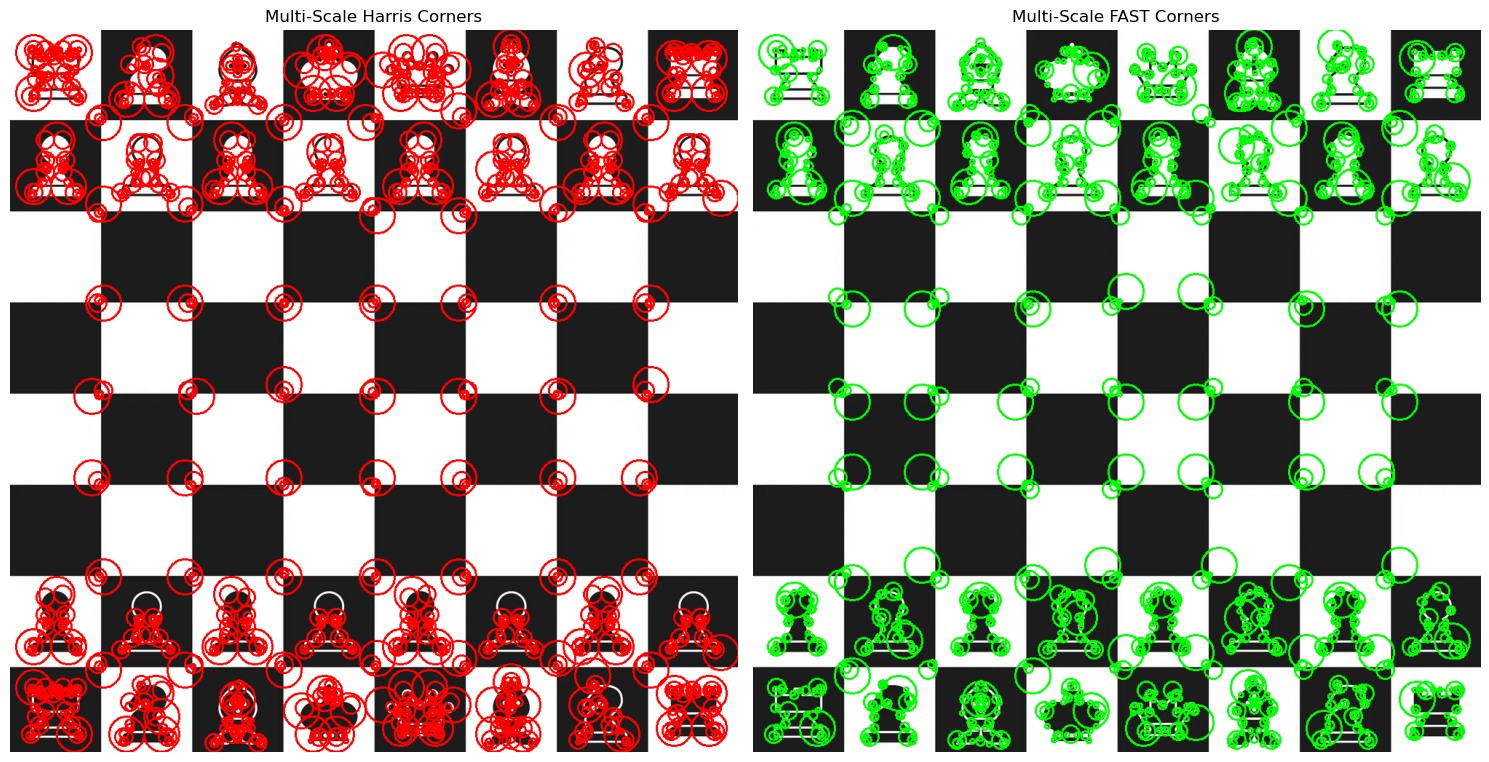

In [2]:
"""
Project: Multi-Scale Harris & FAST Corner Detection
Author: Raj Antala

Description:
This project implements multi-scale (image pyramid based) corner detection
using Harris and FAST detectors. The goal is to detect both fine and coarse
features by running detection at multiple resolutions and mapping them back
to the original image.

Key Concepts:
- Image pyramids
- Scale-space feature detection
- Non-Maximum Suppression (NMS)
- Rotation and scale robustness

Libraries:
- OpenCV
- NumPy
- SciPy
- Matplotlib
"""

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, uniform_filter, maximum_filter
import os

# =============================================================================
# 1. SINGLE-SCALE HARRIS (CORE LOGIC)
# =============================================================================
def harris_corners_single_scale(gray_img, block_size=3, k=0.04, top_n=500, nms_radius=5):
    """
    Detect Harris corners on a single image scale.

    Steps:
    1. Compute image gradients
    2. Build structure tensor
    3. Compute Harris response
    4. Apply Non-Maximum Suppression
    5. Keep top-N strongest corners
    """
    img = gray_img.astype(np.float32)

    # Image gradients
    Ix = sobel(img, axis=1, mode='reflect')
    Iy = sobel(img, axis=0, mode='reflect')

    # Structure tensor components
    window_area = block_size ** 2
    Sxx = uniform_filter(Ix**2, size=block_size) * window_area
    Syy = uniform_filter(Iy**2, size=block_size) * window_area
    Sxy = uniform_filter(Ix*Iy, size=block_size) * window_area

    # Harris response
    det_M = (Sxx * Syy) - (Sxy ** 2)
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)

    # Non-Maximum Suppression
    local_max = maximum_filter(R, size=nms_radius)
    threshold = 0.01 * R.max()
    mask = (R == local_max) & (R > threshold)

    y, x = np.nonzero(mask)
    scores = R[y, x]

    # Keep strongest responses
    if len(scores) > top_n:
        idx = np.argsort(scores)[::-1][:top_n]
        return list(zip(y[idx], x[idx]))

    return list(zip(y, x))


# =============================================================================
# 2. SINGLE-SCALE FAST (CORE LOGIC)
# =============================================================================
def fast_corners_single_scale(gray_img, threshold=20, n=9, nms_radius=7):
    """
    Detect FAST corners on a single image scale.
    Uses OpenCV FAST + custom NMS to remove clustering.
    """
    fast = cv2.FastFeatureDetector_create(threshold=threshold)
    keypoints = fast.detect(gray_img, None)

    # Convert to simple list for custom NMS
    raw = [(kp.response, int(kp.pt[1]), int(kp.pt[0])) for kp in keypoints]

    # Sort by strength
    raw.sort(key=lambda x: x[0], reverse=True)

    final = []
    mask = np.zeros(gray_img.shape, dtype=bool)
    h, w = gray_img.shape

    # Score-based NMS
    for score, cy, cx in raw:
        if mask[cy, cx]:
            continue

        final.append((cy, cx))
        y0, y1 = max(0, cy-nms_radius), min(h, cy+nms_radius+1)
        x0, x1 = max(0, cx-nms_radius), min(w, cx+nms_radius+1)
        mask[y0:y1, x0:x1] = True

    return final


# =============================================================================
# 3. MULTI-SCALE DETECTION (IMAGE PYRAMID)
# =============================================================================
def detect_multiscale(image, method='harris', levels=3, scale_factor=0.5):
    """
    Runs corner detection across multiple scales.

    Process:
    - Build image pyramid
    - Detect corners at each level
    - Map coordinates back to original resolution
    """
    multiscale_corners = []
    current_img = image.copy()
    scale_multiplier = 1.0

    print(f"\n--- Running Multi-Scale {method.upper()} ---")

    for level in range(levels):
        # Detect at current scale
        if method == 'harris':
            pts = harris_corners_single_scale(current_img)
        else:
            pts = fast_corners_single_scale(current_img)

        print(f"Level {level} | Scale: {scale_multiplier:.2f} | Corners: {len(pts)}")

        # Map back to original image
        for y, x in pts:
            orig_y = y * scale_multiplier
            orig_x = x * scale_multiplier
            radius = max(3, int(3 * scale_multiplier))
            multiscale_corners.append((orig_y, orig_x, radius))

        # Downsample for next level
        if level < levels - 1:
            current_img = cv2.GaussianBlur(current_img, (5, 5), 1.0)
            current_img = cv2.resize(
                current_img, None,
                fx=scale_factor, fy=scale_factor
            )
            scale_multiplier *= (1 / scale_factor)

    return multiscale_corners


# =============================================================================
# 4. MAIN PIPELINE
# =============================================================================
def main():
    image_path = "chess-board.jpg"

    # Load image or generate fallback
    if not os.path.exists(image_path):
        print("Image not found. Generating synthetic chessboard...")
        img = np.zeros((512, 512), dtype=np.uint8)
        for y in range(0, 512, 40):
            for x in range(0, 512, 40):
                if (x//40 + y//40) % 2 == 0:
                    img[y:y+40, x:x+40] = 200
        img = cv2.GaussianBlur(img, (3, 3), 1.0)
    else:
        original = cv2.imread(image_path)
        img = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
        print(f"Loaded image: {image_path} | Shape: {img.shape}")

    # Run multi-scale detectors
    harris_ms = detect_multiscale(img, method='harris', levels=4)
    fast_ms = detect_multiscale(img, method='fast', levels=4)

    # Visualization helper
    def draw_multiscale(image_gray, corners, color):
        out = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR)
        for y, x, r in corners:
            cv2.circle(out, (int(x), int(y)), int(r), color, 2)
        return out

    out_harris = draw_multiscale(img, harris_ms, (0, 0, 255))
    out_fast = draw_multiscale(img, fast_ms, (0, 255, 0))

    # Display results
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(out_harris, cv2.COLOR_BGR2RGB))
    plt.title("Multi-Scale Harris Corners")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(out_fast, cv2.COLOR_BGR2RGB))
    plt.title("Multi-Scale FAST Corners")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
